**CONSTANT HEIGHT STM IMAGES**
------------------------------


Theory Background
-----------------

Prediction of STM images requires a knowledge of the **electronic structure** of the molecule and a theory of how STM works.

The standard theory of how STM works is based on the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998):
**the tunneling current is proportional to the local density of states (LDOS)**:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$
The LDOS at a certain energy is calculated from the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy.

The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

In summary, to compute constant height STM images, we need:

1.- Obtain atomic coordinates (for example, from a previous geometry optimization calculation)

2.- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies). We will use **SIESTA** for this.

3.- Compute electron density of selected states and compute the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ (at a constant height $z$), given the voltage bias $V$. We will use **python** for this.

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

Python implementation of STM simulation
---------------------------------------
We first import of required libraries

In [1]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt

## Analysis of SIESTA Results
**Load SIESTA Calculation**

Once the SIESTA run has finished, to load SIESTA results into python you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

In [2]:
fdf = get_sile("../run/stm.fdf")

In [3]:
H = fdf.read_hamiltonian()

In [4]:
molec = H.geometry

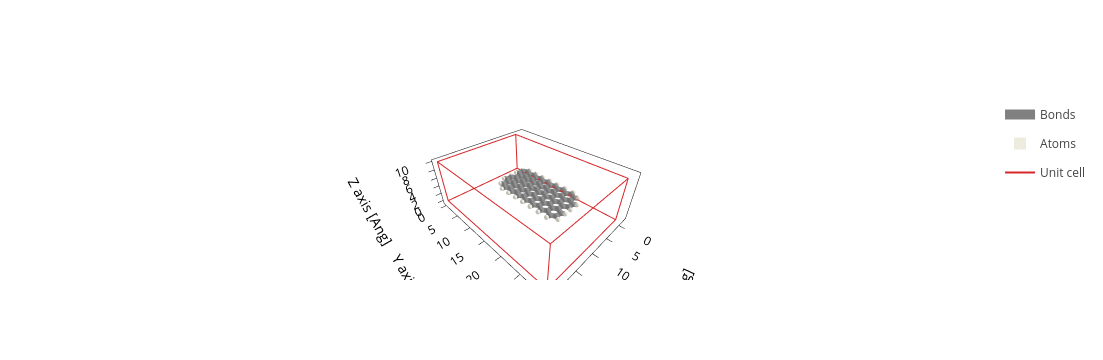

In [6]:
molec.plot()

## Eigenstates

Once you have a hamiltonian, you can get all Eigenstates with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. 
- Each eigenstate has its energy stored under the `.eig` property.
- We can find the HOMO and LUMO.
- We can use the `.dos`  method to obtain the density of states DOS(E).
- In sisl we can plot pdos directly in a given Energy range with something like `H.plot.pdos(data_Erange=[-10,10],nE=1200,Erange=[-10,10]) `

In [7]:
es=H.eigenstate()

In [8]:
es.eig

array([-19.25697653, -19.05384188, -18.72540811, ..., 137.03766033,
       147.41022392, 160.0075576 ])

In [10]:
idx_lumo = (es.eig > 0).nonzero()[0][0] #trick to obtain the LUMO as first positive eigenvalue

In [11]:
print(idx_lumo)

168


In [12]:
print("HOMO E=",es.eig[idx_lumo-1]," eV")
print("LUMO E=",es.eig[idx_lumo]," eV")

HOMO E= -0.0017333788451005562  eV
LUMO E= 0.0017332178350958141  eV


-----------------------------------------------------------------------------------
## Plotting Local Density of States

Create a grid and fill the grid with LDOS

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid(geometry, shape=(100, 100, 100))`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.
4. Once you have the wavefunction, you can calculate the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$.
5. The result can be saved in a '.cube' file and plotted with VMD 

Remember that we have done this already on the first SIESTA lab, with a water molecule and with $C_{60}$.


In [13]:
g = Grid(0.2, lattice=molec.lattice)  #defines a grid matching with our system

Save a state (for example, LUMO) in cube file

In [14]:
es[idx_lumo].wavefunction(g)
g.write('LUMO.cube')

g.fill(0) # reset the grid values to 0

info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



Save Electron Density

In [15]:
g2 = Grid(0.2, lattice=molec.lattice) 

In [16]:
es[idx_lumo].wavefunction(g)
g2=g*g.grid.conj() 
g2.write('LUMOdens.cube')
g2.fill(0) # reset the grid values to 0

info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



We can easily save the electron density including a range of states

In [17]:
Gt = Grid(0.2, lattice=molec.lattice) 
for n in range(idx_lumo-4,idx_lumo):
    print("adding state",n)
    g.fill(0)
    es[n].wavefunction(g)
    Gt = Gt + g*g.grid.conj()
Gt.write('several_states.cube')
Gt.fill(0)

    

adding state 164


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 165


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 166


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 167


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



# STM images #

**Remember**: The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

Now we can create a function `STM_grid(H, V)` that creates a grid adding all the states that contribute to the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$ relevant to the STM image.

The `STM_grid(H, V)` function need the Hamitonian (the object `H`) and the value of the voltage `V`.

In [18]:
def STM_grid(H, V):
    gridT = sisl.Grid((100, 100, 100), geometry=molec)
    grid = sisl.Grid((100, 100, 100), geometry=molec)
    gridT.fill(0)
    E=-V
    for i in range(0,len(es)):
        #Negative V: electrons go from tip to sample filling unoccupied states from 0 to E
        if 0<es[i].eig<E:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT
        #Positive V: electrons with energies between E and 0 leave the sample and go to the tip
        if E<es[i].eig<0:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT 
    result=gridT
    return result

Calculate and save data. IN VMD you can use isosurface or Volume slice representations

In [22]:
V=STM_grid(H, 5)

adding state 128


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 129


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 130


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 131


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 132


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 133


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 134


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 135


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 136


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 137


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 138


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 139


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 140


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 141


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 142


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 143


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 144


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 145


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 146


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 147


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 148


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 149


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 150


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 151


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 152


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 153


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 154


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 155


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 156


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 157


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 158


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 159


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 160


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 161


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 162


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 163


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 164


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 165


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 166


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 167


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



In [23]:
V.write('STM_5Volt.cube')

In [24]:
V=STM_grid(H, -3)
V.write('STM_m3Volt.cube')

adding state 168


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 169


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 170


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 171


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 172


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 173


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 174


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 175


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 176


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 177


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 178


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 179


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 180


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information



adding state 181


info:0: SislInfo:

wavefunction: coordinates may be outside your primary unit-cell. Translating all into the primary unit cell could disable this information

